# Snow Drought Reoccurance Analysis
 - We first look at month to month reoccurance 

In [1]:
from imports import *
from netCDF4 import Dataset # for saving netcdfs 
from cartopy.feature import ShapelyFeature # for plotting HUC2 regions
from cartopy.io.shapereader import Reader
from joblib import Parallel, delayed
import scipy.stats as st # for easy confidence intervals using student-t
import math

# axes grid for 
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
from shapely.ops import cascaded_union # for uncertainty cones


states = cfeature.NaturalEarthFeature(category='cultural',
                                     name='admin_1_states_provinces_shp',
                                     scale='50m',
                                     facecolor='none',
                                     edgecolor='black',
                                     linewidth=1)
def is_winter(month):
    return (month <=4) | (month >=10)

# Monthly Reoccurrence
Compute the probability of snow drought for historical period. Look at annual distribution of droughts going forward.
 - Do we wee increased droughts in particular months (eg fall/winter)?
 - How does the probability of monthly drought reoccurrence change?

In [4]:
# load sample file 
# load mask and sample ensemble member
mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")

# concat historical and future ds
snowi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/hist/hist_monthly_ens_01.nc")
snowi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/future/future_monthly_ens_01.nc")
snowi = xr.concat([snowi_hist, snowi_future], dim='time').sortby('time')


In [12]:
SD = (snowi.zscores < -1.3).where(mask_ds.expand_dims(dim={'time':
                                        snowi.time})>20).sel(time=is_winter(snowi['time.month']))

In [24]:
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
month_sds = {}
for month in [1,2,3,4,10,11,12]: # winter months
    dec_ar = []
    for decade in decades:
        SD_month = SD.sel(time=SD['time.month']==month).sel(time=slice(decade[0], decade[1]))
        dec_ar.append(int(SD_month.snow.sum()))
    month_sds[str(month).zfill(2)] = dec_ar

In [47]:
SD.sel(time=SD['time.month']==10).sel(time=(slice("1921", "1930"))).time

<xarray.DataArray 'time' (time: 10)>
array([cftime.DatetimeJulian(1921, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1922, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1923, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1924, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1925, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1926, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1927, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1928, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1929, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1930, 10, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1921-10-16 12:00:00 ... 1930-10-16 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   JULIAN
    bounds:          time_bnds

In [52]:
def get_monthly(ensemble_str, threshold : int =-1.3):
    
    # num snowy cells 
    num_snowy = int((mask_ds.snow > 20).sum())
    
    # concat historical and future ds
    snowi_hist   = xr.open_dataset(f"/work/Julian.Schmitt/data/zscores/snowi/hist/hist_monthly_ens_{ensemble_str}.nc")
    snowi_future = xr.open_dataset(f"/work/Julian.Schmitt/data/zscores/snowi/future/future_monthly_ens_{ensemble_str}.nc")
    snowi = xr.concat([snowi_hist, snowi_future], dim='time').sortby('time')
    
    # select winter months and aggregate
    SD = (snowi.zscores < threshold).where(mask_ds.expand_dims(dim={'time':
                                        snowi.time})>20).sel(time=is_winter(snowi['time.month']))
    
    decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
    month_sds = {}
    for month in [1,2,3,4,10,11,12]: # winter months
        dec_ar = []
        for decade in decades:
            SD_month = SD.sel(time=SD['time.month']==month).sel(time=slice(decade[0], decade[1]))
            dec_ar.append(int(SD_month.snow.sum()))
            
        month_sds[str(month).zfill(2)] = np.array(dec_ar) / (num_snowy* len(SD_month.time))
    return month_sds

In [54]:
monthly_dicts = [get_monthly(str(num).zfill(2)) for num in range(1,31)]

In [85]:
import scipy.stats as st
mean_dict, std_dict = {}, {}
for month in months:
    month_means, month_stds = [],[]
    for ind, decade in enumerate(range(1920, 2100, 10)):
        spread = [elt[ind] for elt in [monthly_dicts[i][month] for i in range(30)]]
        m, s = np.mean(spread), np.std(spread)
        month_means.append(m)
        month_stds.append(s)
    mean_dict[month] = np.array(month_means)
    std_dict[month] = np.array(month_stds)

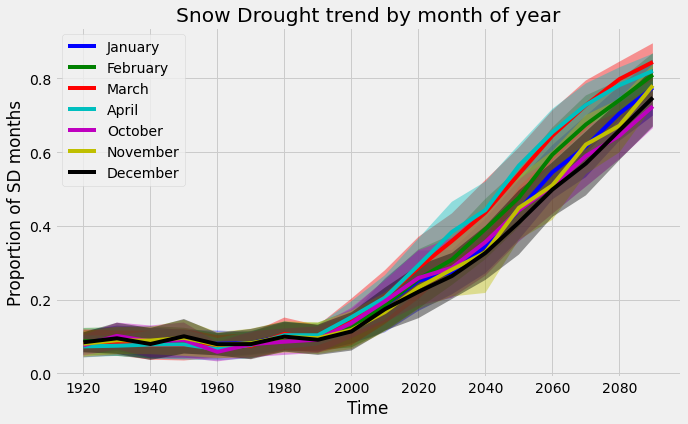

In [97]:
plt.figure(figsize=(10,6))

for ind, month in enumerate(months):
    # average ensemble dicts
    plt.plot(range(1920, 2100, 10), mean_dict[month], label=month_names[ind])
    plt.fill_between(range(1920, 2100, 10), mean_dict[month]-std_dict[month], mean_dict[month]+std_dict[month],
                    alpha=0.4)
plt.xticks(range(1920, 2100, 20))
plt.legend()
plt.xlabel("Time")
#plt.xlim(2000, 2100)
plt.ylabel("Proportion of SD months")
plt.title("Snow Drought trend by month of year");
plt.savefig("/home/Julian.Schmitt/plots/SD_by_month_spread.png", dpi=200)

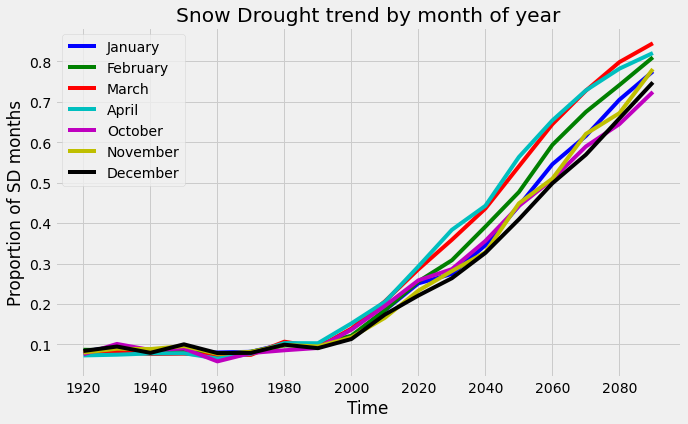

In [69]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
from cycler import cycler
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
# loop through and plot month trend lines
months =["01", "02", "03", "04", "10", "11", "12"]
month_names = ["January", "February", "March", "April", "October", "November", "December"]

for ind, month in enumerate(months):
    # average ensemble dicts
    agg_month = np.mean([monthly_dicts[i][month] for i in range(30)], axis=0)
    plt.plot(range(1920, 2100, 10), agg_month, label=month_names[ind])
plt.xticks(range(1920, 2100, 20))
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion of SD months")
plt.title("Snow Drought trend by month of year");
plt.savefig("/home/Julian.Schmitt/plots/SD_by_month.png", dpi=200)

# year on year drought reoccurrence 

In [32]:
def repeating_drought(ensemble_str, threshold : int =-1.3):
    
    # num snowy cells 
    num_snowy = int((mask_ds.snow > 20).sum())
    
    # concat historical and future ds
    snowi_hist   = xr.open_dataset(f"/work/Julian.Schmitt/data/zscores/snowi/hist/hist_monthly_ens_{ensemble_str}.nc")
    snowi_future = xr.open_dataset(f"/work/Julian.Schmitt/data/zscores/snowi/future/future_monthly_ens_{ensemble_str}.nc")
    snowi = xr.concat([snowi_hist, snowi_future], dim='time').sortby('time')
    
    # select winter months and aggregate
    annual_snowi = (snowi.zscores < threshold).where(mask_ds.expand_dims(dim={'time':snowi.time})>20).sel(time=
                                                is_winter(snowi['time.month'])).resample(time="AS-OCT").sum()
    prop_repeating, baseline = [], []
    for i in range(len(annual_snowi.time)-1):
        base, num = np.sum((annual_snowi >2).snow[i]), None
        try:
            num = np.sum((annual_snowi >2).snow[i] & (annual_snowi >2).snow[i+1])/base
        except:
            num=0
        prop_repeating.append(num)
        baseline.append(base/num_snowy)

    return [np.nan_to_num(np.array(prop_repeating)), np.nan_to_num(np.array(baseline))]

In [49]:
%%time
ncores=os.cpu_count()
dry_base = Parallel(n_jobs=ncores)(delayed(repeating_drought)(str(i).zfill(2), -2.2) for i in range(1,31))
droughts, baseline = [elt[0] for elt in dry_base], [elt[1] for elt in dry_base]

CPU times: user 125 ms, sys: 3 ms, total: 128 ms
Wall time: 2.27 s


In [50]:
drought_ensmean = np.mean(droughts, axis=0)
drought_std = 1.96*np.std(droughts, axis=0)/np.sqrt(30)
baseline_ensmean= np.mean(baseline, axis=0)
baseline_std = 1.96*np.std(baseline, axis=0)/np.sqrt(30)

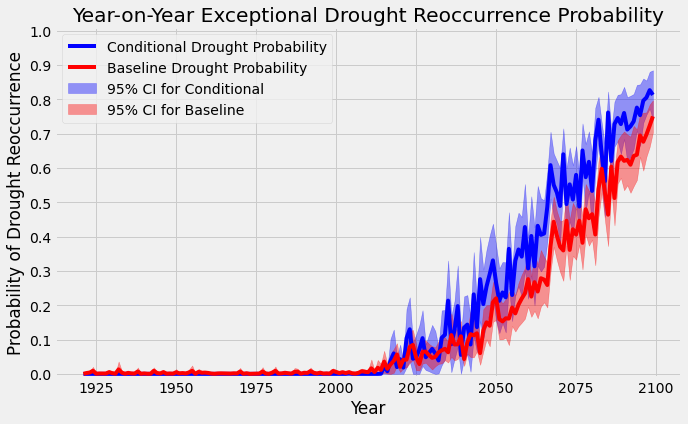

In [51]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
plt.plot(np.arange(1921, 2100), drought_ensmean[:-1], color='blue', label="Conditional Drought Probability")
# add ensemble spread - limit spread probabilities to between 0 and 1
plt.fill_between(np.arange(1921, 2100), np.max([np.full((179,), 0), drought_ensmean[:-1]-drought_std[:-1]],axis=0), 
                 np.min([np.full((179,), 1), drought_ensmean[:-1]+ drought_std[:-1]], axis=0), 
                 alpha=0.4, color='blue', label="95% CI for Conditional")

# add baseline probability
plt.plot(np.arange(1921, 2100), baseline_ensmean[:-1], color='red', label="Baseline Drought Probability")
# add ensemble spread - limit spread probabilities to between 0 and 1
plt.fill_between(np.arange(1921, 2100), np.max([np.full((179,), 0), baseline_ensmean[:-1]-baseline_std[:-1]],axis=0), 
                 np.min([np.full((179,), 1), baseline_ensmean[:-1]+ baseline_std[:-1]], axis=0), 
                 alpha=0.4, color='red', label="95% CI for Baseline")

plt.xlabel("Year")
plt.legend()
plt.ylim(-0.01, 1.01) # keep lines
plt.yticks(np.arange(0, 1.01, 0.1))
plt.ylabel("Probability of Drought Reoccurrence")
plt.title("Year-on-Year Exceptional Drought Reoccurrence Probability");
#plt.savefig("/home/Julian.Schmitt/plots/yearonyear_drought_reoccurrence_20.png", dpi=200)

In [52]:
diff = drought_ensmean-baseline_ensmean
diff_std = 1.96*np.sqrt((29*np.square(np.std(droughts, axis=0))+29*np.std(baseline, axis=0))/(30+30-2))/np.sqrt(30)

In [71]:
%%time
# get differences
rate_diff, rate_std = {}, {}
rates = [0, -0.8,-1.3,-1.6, -2.0, -2.3]
for rate in rates:
    dry_base = Parallel(n_jobs=ncores)(delayed(repeating_drought)(str(i).zfill(2),rate) for i in range(1,31))
    droughts, baseline = [elt[0] for elt in dry_base], [elt[1] for elt in dry_base]
    
    drought_ensmean = np.mean(droughts, axis=0)
    drought_std = 1.96*np.std(droughts, axis=0)/np.sqrt(30)
    baseline_ensmean= np.mean(baseline, axis=0)
    baseline_std = 1.96*np.std(baseline, axis=0)/np.sqrt(30)
    
    diff = drought_ensmean-baseline_ensmean
    diff_std = 1.96*np.sqrt((29*np.square(np.std(droughts, axis=0))+29*np.std(baseline, axis=0))/(30+30-2))/np.sqrt(30)
    
    rate_diff[rate]=  diff
    rate_std[rate] = diff_std

CPU times: user 765 ms, sys: 17 ms, total: 782 ms
Wall time: 14.3 s


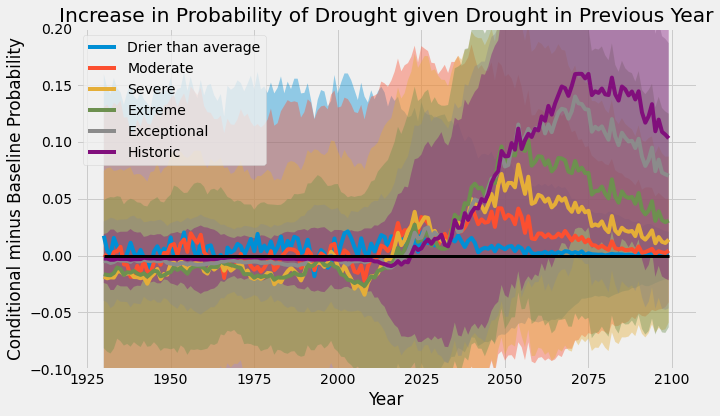

In [97]:
plt.figure(figsize=(10,6))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

drought_labels =["Drier than average", "Moderate", "Severe", "Extreme", "Exceptional", "Historic"]
for ind, rate in enumerate(rates):
    w= 10
    diff = moving_average(rate_diff[rate], w)
    std = moving_average(rate_std[rate], w)
    plt.plot(np.arange(1921+w-1, 2100), diff[:-1], label=drought_labels[ind])
    plt.fill_between(np.arange(1921+w-1, 2100), (diff-std)[:-1], (diff+std)[:-1], alpha=0.4)

#plt.xlim(2000, 2100)
plt.ylim(-0.1, 0.2)
plt.legend()
plt.axhline(0, xmin=0.045, xmax=0.955, color='k', linewidth=3)
plt.xlabel("Year")
plt.ylabel("Conditional minus Baseline Probability")
plt.title("Increase in Probability of Drought given Drought in Previous Year");
plt.tight_layout()
plt.savefig("/home/Julian.Schmitt/plots/drought_increase_by_threshold.png", dpi=200)

(-1.0, 1.0)

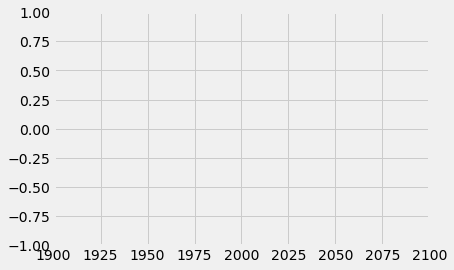

In [92]:
plt.axhline(y=0, xmin=1931, xmax=2099, color='k', linewidth=4)
plt.xlim(1900, 2100)
plt.ylim(-1,1)